In [1]:
import os
import sys
from IPython.display import display, clear_output
import tensorflow as tf

sys.path.append(os.path.abspath("../"))
from src.utils import reload_script
from models_src.Support import LRCallback

clear_output(wait=True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1732880481.915283   74614 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732880481.924596   74614 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732880481.925158   74614 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# set up databases
config_path = "../exp_lib/general_config/pixel_features.json"
%run -i ../exp_lib/datasets_generators/pixel_features.py {config_path}
clear_output(wait=True)

I0000 00:00:1732880482.576608   74614 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732880482.576817   74614 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732880482.576862   74614 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732880483.019342   74614 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732880483.019526   74614 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-29

In [3]:
# set up mlflow instance
%run -i ../exp_lib/mlflow/local_experiment.py {cfg.experiment_name}

In [4]:
# set up Trainer
#model_def_path = "../exp_lib/model_def/radial_enc_pixel_features_backboned.json"
model_def_path = "../exp_lib/model_def/radial_enc_pixel_features_pure.json"
trainer = None
%run -i ../exp_lib/utils/trainer_loader.py {model_def_path}

GridBox(children=(Text(value='frequency', description='enc_type', layout=Layout(height='30px', width='300px'),…

Button(description='Accept Parameters', style=ButtonStyle())

Dictionary updated: {'enc_type': 'frequency', 'num_heads': 1, 'embs_dim': 64, 'color_embs_dim': 64, 'size': 32, 'embs_mid_layers': 2, 'dropout': 0.0, 'activation': 'relu', 'out_mid_layers': 2, 'attns_num': 3, 'concat_memory': False, 'progressive': True, 'inverted_angle': False, 'backbone_def': None, 'backbone_trainable': None, 'backbone_last_layer': None, 'backbone_init_layer': None}
Colors only mode ON. Any backbone arguments provided are ignored.
(1, 1024, 1024, 64) (None, 1024, 64)


/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'MHA_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'MHA_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'MHA_3', however the 

Model: "PxFeaturesRadEnc"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Conne
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━
│ input_layer (InputLayer)    │ (None, 32, 32, 3)       │              0 │ -    
├─────────────────────────────┼─────────────────────────┼────────────────┼──────
│ Batch-Normalization         │ (None, 32, 32, 3)       │             12 │ input
│ (BatchNormalization)        │                         │                │      
├─────────────────────────────┼─────────────────────────┼────────────────┼──────
│ RSFE                        │ [(None, 1024, 64), (1,  │         25,280 │ Batch
│ (RadialSearchFeaturesExtra… │ 1024, 1024, 64)]        │                │      
├─────────────────────────────┼─────────────────────────┼────────────────┼──────
│ MHA_1 (SelfRadialMHA)       │ [(None, 1024, 64),      │         12,480 │ RSFE[
│ 

In [5]:
trainer.train_model(
    epochs = 80,
    callbacks = [LRCallback(warmup_lr=1e-5, warmup_epochs=1, decay_ratio=0.96)],
    log = True,
    export_final_state = True,
    export_model = False,
    export_model_def = True
)

512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - angle_loss: 0.1414 - center_vec_loss: 0.2399 - loss: 0.9796 - shape_class_F1: 0.4021 - shape_class_loss: 0.1519 - thickness_loss: 0.4463

2024-11-29 12:43:24.005661: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 316 bytes spill stores, 268 bytes spill loads

2024-11-29 12:43:24.968559: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 368 bytes spill stores, 368 bytes spill loads

2024-11-29 12:43:25.606565: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 8 bytes spill stores, 8 bytes spill loads

2024-11-29 12:43:26.084388: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2', 12 bytes spill stores, 12 bytes spill loads

2024-11-29 12:43:26.613370: I external/local_xla/xla/stream_executor/

512/512 ━━━━━━━━━━━━━━━━━━━━ 102s 97ms/step - angle_loss: 0.1414 - center_vec_loss: 0.2399 - loss: 0.9795 - shape_class_F1: 0.4024 - shape_class_loss: 0.1518 - thickness_loss: 0.4463 - val_angle_loss: 0.1391 - val_center_vec_loss: 0.2271 - val_loss: 0.8697 - val_shape_class_F1: 0.7337 - val_shape_class_loss: 0.1013 - val_thickness_loss: 0.4022 - learning_rate: 1.0000e-05
Epoch 2/80
512/512 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - angle_loss: 0.1411 - center_vec_loss: 0.2494 - loss: 0.8863 - shape_class_F1: 0.7390 - shape_class_loss: 0.0870 - thickness_loss: 0.4089 - val_angle_loss: 0.1383 - val_center_vec_loss: 0.2171 - val_loss: 0.6737 - val_shape_class_F1: 0.9288 - val_shape_class_loss: 0.0370 - val_thickness_loss: 0.2813 - learning_rate: 0.0010
Epoch 3/80
512/512 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - angle_loss: 0.1300 - center_vec_loss: 0.1953 - loss: 0.6170 - shape_class_F1: 0.9437 - shape_class_loss: 0.0298 - thickness_loss: 0.2618 - val_angle_loss: 0.0727 - val_center_vec_loss: 0.115

2024/11/29 13:26:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-cat-453 at: http://localhost:5000/#/experiments/806955696090293906/runs/d172ea2201ac481a9313189836776d90.
2024/11/29 13:26:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/806955696090293906.


In [ ]:
trainer.upload_weights_to_mlflow()

In [ ]:
from exp_lib.utils.load_mlflow_model import load_mlflow_model
model = load_mlflow_model(run_name='carefree-gnat', load_weights=True, compile=True)

In [6]:
# Metric validation
%run -i ../exp_lib/metric_validation/unet_pixel_features.py --upload=1

256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - val_shape_class_loss: 0.0335 - val_angle_loss: 0.0741 - val_thickness_loss: 0.2087 - val_center_vec_loss: 0.1805
loss_value: 0.12421328


2024/11/29 13:27:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-cat-453 at: http://localhost:5000/#/experiments/806955696090293906/runs/d172ea2201ac481a9313189836776d90.
2024/11/29 13:27:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/806955696090293906.


[0.9993666, 0.9972551, 0.99532175]


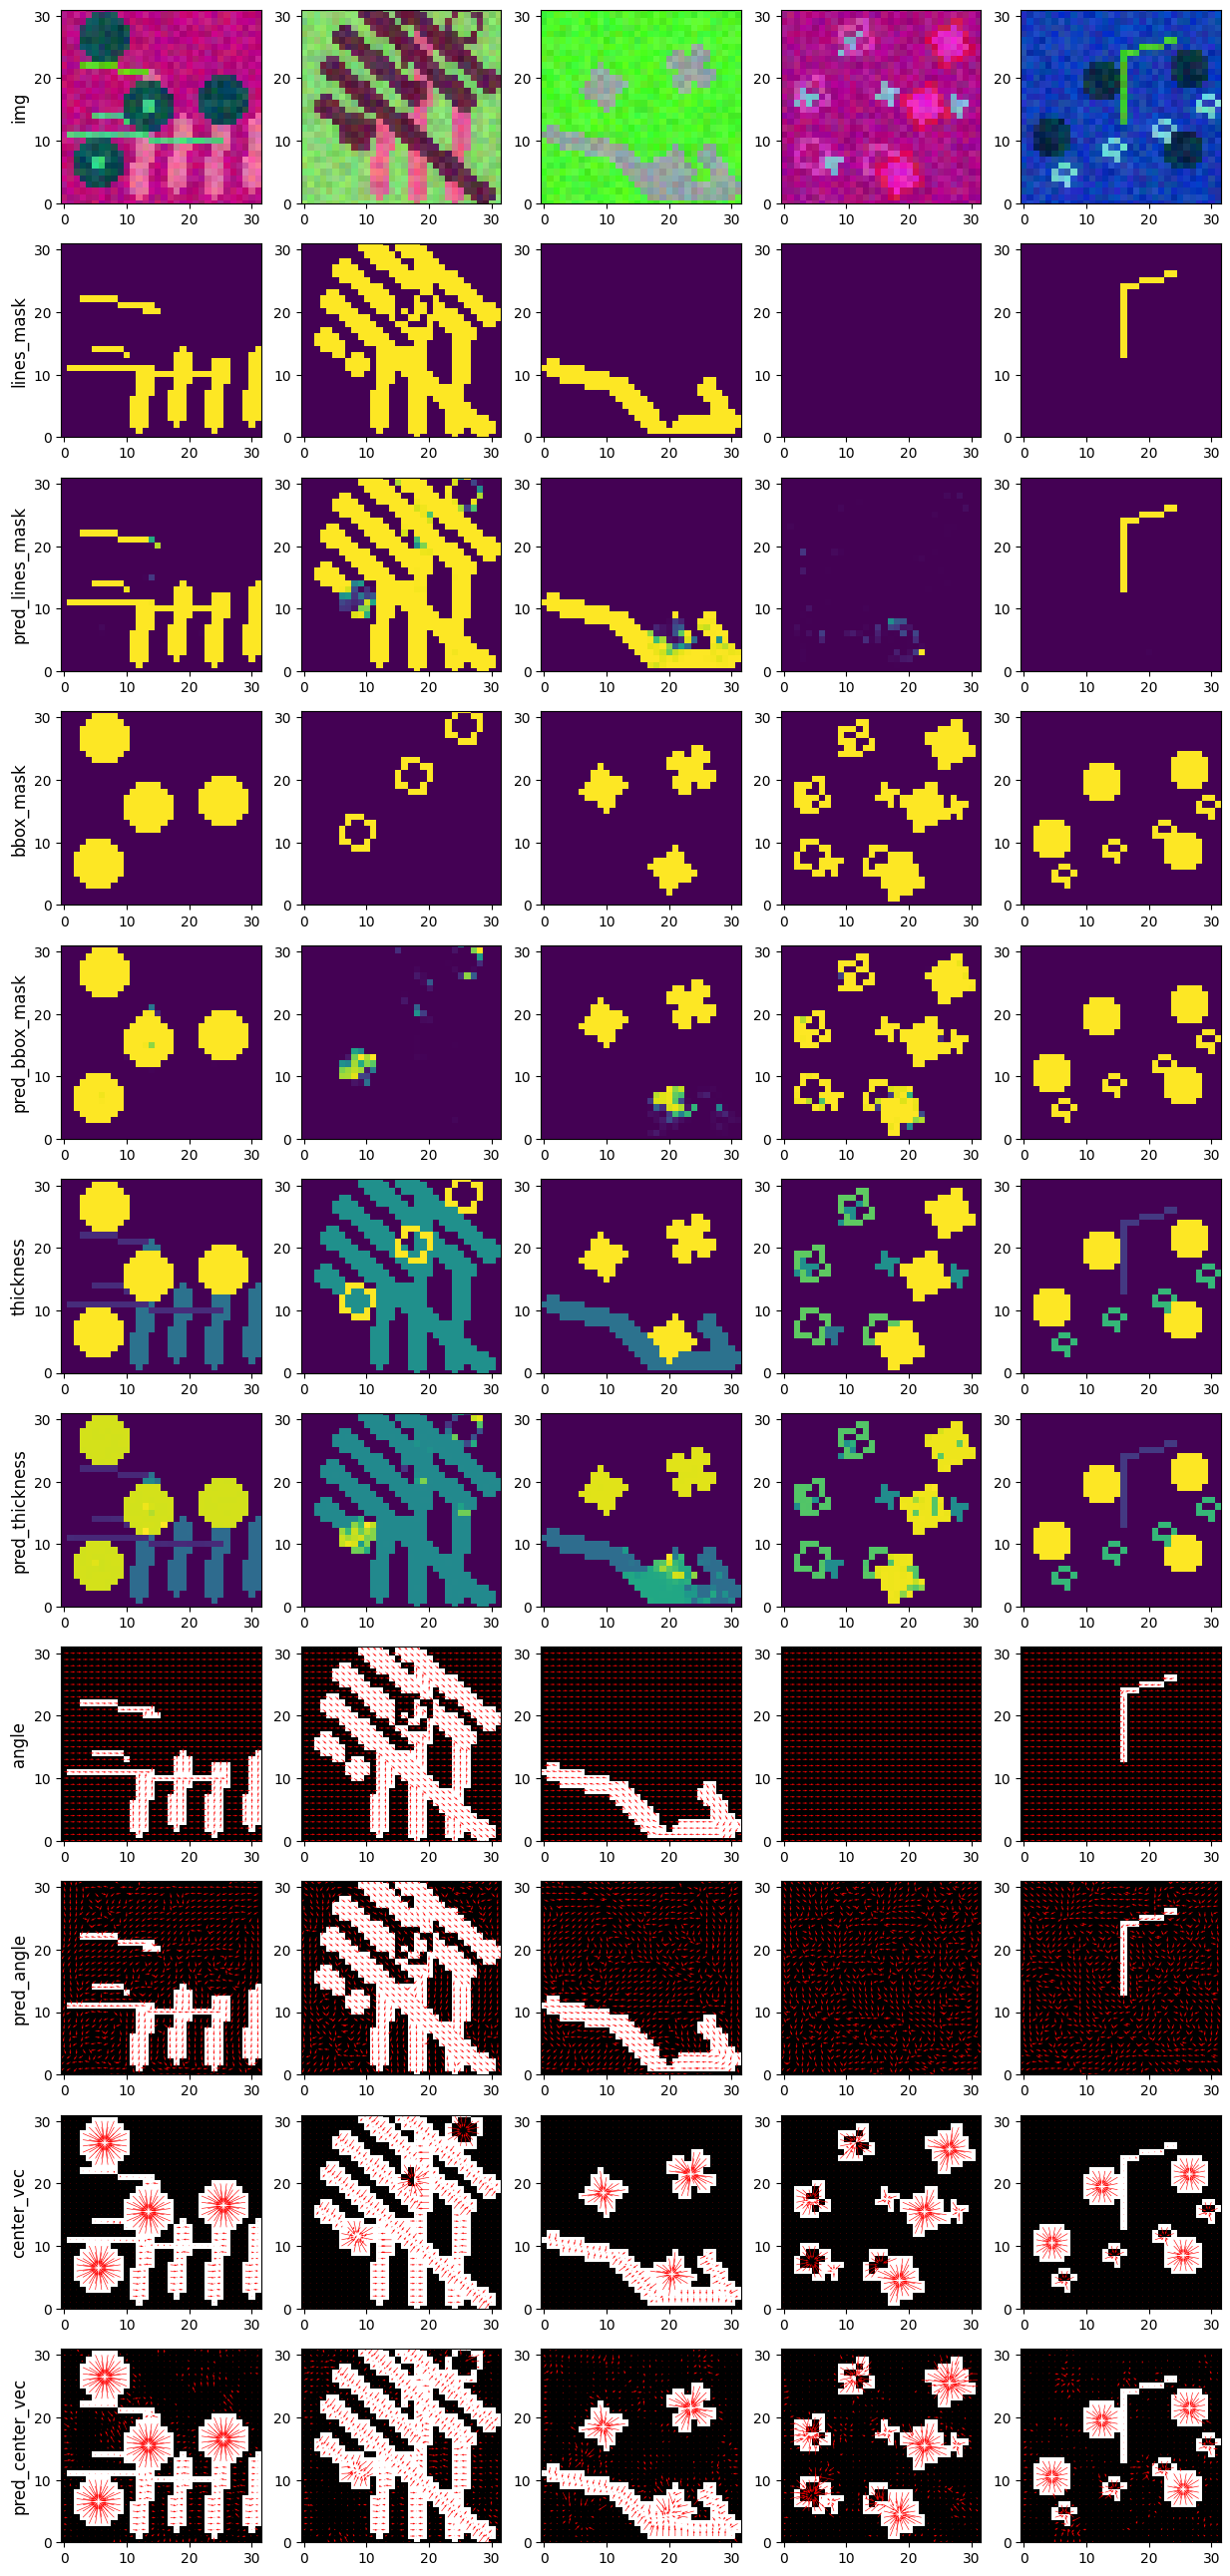

In [7]:
# Plot results
%run -i ../exp_lib/plots/unet_pixel_features.py --s=5

# MHA weights

In [49]:
from models_src.fft_lib import encode1Dcoords

In [50]:
inter_model = tf.keras.Model(trainer.model.input, (trainer.model.get_layer('MHA_1').output[0], 
                                                   trainer.model.get_layer('MHA_1').output[1], 
                                                   trainer.model.get_layer('RSFE').output[1]))

learned_pos_enc, attn_mask, pos_enc = inter_model(img, training=False)
learned_pos_enc = tf.matmul(attn_mask[:,0,:,tf.newaxis], pos_enc)[:,:,0]
print(learned_pos_enc.shape, attn_mask.shape, pos_enc.shape)
flat_coord = encode1Dcoords(tf.constant([18,5]), width=32)[0]

sub_attn_mask = tf.reshape(attn_mask[1,0,flat_coord], (32,32))
sub_learned_pos_enc = learned_pos_enc[1,flat_coord,tf.newaxis]
sub_pos_enc = pos_enc[0,flat_coord]

print(sub_learned_pos_enc.shape, sub_pos_enc.shape)

learned_pos_map = tf.matmul(sub_learned_pos_enc, sub_pos_enc, transpose_b=True)
print(learned_pos_map.shape)
learned_pos_map = tf.reshape(learned_pos_map, (32,32))

(8, 1024, 64) (8, 2, 1024, 1024) (1, 1024, 1024, 64)
(1, 64) (1024, 64)
(1, 1024)


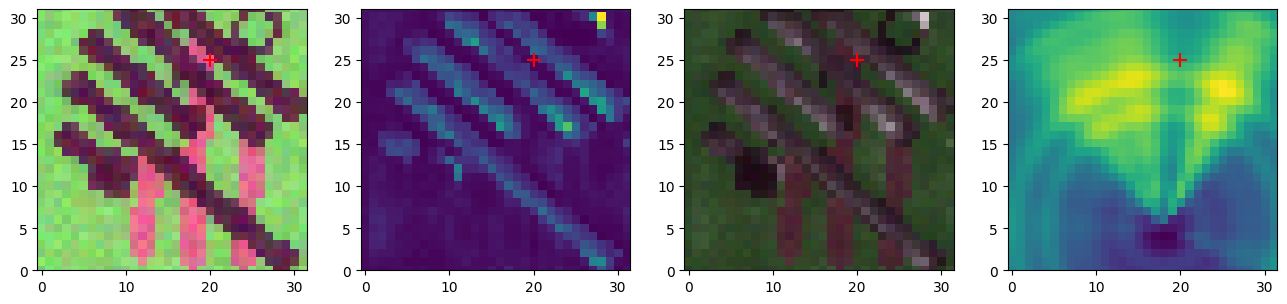

In [51]:

fig, axs = plt.subplots(1,4, figsize=(16,4))
axs[0].imshow(img[1])
axs[1].imshow(sub_attn_mask)

axs[2].imshow(img[1])
axs[2].imshow(sub_attn_mask, cmap='gray', alpha=0.7)

axs[3].imshow(learned_pos_map)
for i in range(4):
    axs[i].scatter(20,25, marker='+', color='red', s=100)
    axs[i].set_ylim(0,31)